# Analyzing Voter Fatigue

## Introduction

Legacies in the NBA are defined by 2 items more than anything:
* Championships
* Awards

Whereas championships are earned purely objectively through competition, awards present a more *subjective* element. As a result, the number of awards a player receives is more prone to bias.

A landmark moment to illustrate this pattern was in 2011 when Derrick Rose won the MVP over Lebron James. 

Lebron James was coming off of an incredible year in Miami with just around 27 points, 7.5 rebounds, and 7 assists per game that season with a field goal percentage of 51%. In comparison to Rose’s 25 points, 4 rebounds, and 8 assists with a field goal percentage of 45%, Lebron had the better statistics for that season. But, Lebron had just come off of back-to-back MVP's, so who would want to vote for him again.

This tendency to favor the new candidate over the previous year's winner is known as **voter fatigue**. It is a pattern that occurs for individual awards such as the MVP, DPOY, MIP, SMOY, and COY. 

So, how much does voter fatigue matter for each of the individual awards? This project aims to investigate how much *better* a winner of each individual award must be the following year to repeat.

## Methodology

### Measuring A Candidate's Success
For each award we choose the most relevant statistic that determines the award.

For the MVP, we choose Win Shares (WS) since the MVP should be determined by the player who contributes most to the team's success.

For DPOY, we choose Defensive Win Shares (DFS) since the DPOY should be determined by the player who contributes the most to the team's success *exclusively on the defensive end*.

For MIP, we choose the difference between the player's PER the year they were selected and the player's PER the year prior.

For SMOY, we choose the player's PER that year.

For COY, we choose the difference between the number of wins the team won that year and the number of wins the team was predicted to win ([Pythagorean Wins](https://www.basketball-reference.com/about/glossary.html) on Basketball Reference).

To summarize:

|Award|Metric|
|--|--|
|MVP|WS|
|DPOY|DWS|
|MIP|CURR_PER-PREV_PER|
|SMOY|PER|
|COY|W-PW|

### Measuring A Candidate's Award Voting

For MVP, DPOY, MIP, and SMOY, we aggregate the the share of the points that the player received during voting from the years 1988 onward since award statistics were first released in 1988.

Since the points share is always scaled between 0.0 and 1.0, we will be able to compare between awards appropriately.

Unfortunately, award statistics were only released in 2016 for COY, so our dataset will be much smaller.

### Computing Voter Fatigue

For each award, we compute the difference between the points share the candidate received the following year. Next, we compute the difference between the relevant scaled statistic.

For example (note that WS is not scaled in this example for clarity):

Michael Jordan won the MVP in 1988 with a WS of 21.2 and a PTS_SHARE of 0.831.
In 1989, he lost to Magic Johnson, with a WS of 19.8 and a PTS_SHARE of 0.704.

So the two data points we compute are 21.2-19.8 = 0.4, and 0.831-0.704=0.127

We then plot the difference in the Points Share as a function of the statistic's difference and fit a regression line.

Finally, we find the y-intercept of this regression line.

This y-intercept measures how much better the candidate must perform **if they were to maintain their performance from their previous year AND receive the same points share**.

Using this value, we can quantify voter fatigue for each award.

Let's begin!

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
sns.set()

### MVP Award

In [2]:
df = pd.read_csv('mvp_data.csv')
df.head()

,RANK,PLAYER,AGE,TEAM,FIRST_PLACE_VOTES,TOTAL_POINTS_WON,TOTAL_POINTS_POSSIBLE,POINTS_SHARE,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,SEASON
0,1,Michael Jordan,24,CHI,47.0,665.0,800,0.831,82,40.4,...,5.5,5.9,3.2,1.6,0.535,0.132,0.841,21.2,0.308,1988
1,2,Larry Bird,31,BOS,16.0,527.0,800,0.659,76,39.0,...,9.3,6.1,1.6,0.8,0.527,0.414,0.916,15.0,0.243,1988
2,3,Magic Johnson,28,LAL,16.0,508.0,800,0.635,72,36.6,...,6.2,11.9,1.6,0.2,0.492,0.196,0.853,10.9,0.199,1988
3,4,Charles Barkley,24,PHI,1.0,109.0,800,0.136,80,39.6,...,11.9,3.2,1.3,1.3,0.587,0.280,0.751,16.7,0.253,1988
4,5,Clyde Drexler,25,POR,0.0,86.0,800,0.108,81,37.8,...,6.6,5.8,2.5,0.6,0.506,0.212,0.811,13.2,0.207,1988


In [3]:
l1 = 'WS Year After MVP - WS MVP Year'
l2 = 'PS Year After MVP - PS MVP Year'

chart_df = pd.DataFrame(columns=[l1, l2, 'Player'])
for y in df['SEASON'].unique():
    if y==1988: continue
    prev_y = y-1
    prev_y_df = df[df['SEASON']==prev_y]
    prev_winner = prev_y_df[prev_y_df['RANK']=='1']
    y_df = df[df['SEASON']==y]
    prev_winner_name = prev_winner['PLAYER'].values[0]
    prev_winner_now = y_df[y_df['PLAYER']==prev_winner_name]
    if len(prev_winner_now)==0: continue
    ws_drop_off = prev_winner_now['WS'].values[0]-prev_winner['WS'].values[0]
    ps_drop_off = prev_winner_now['POINTS_SHARE'].values[0]-prev_winner['POINTS_SHARE'].values[0]
    # large ws drop off indicates that someone deserved to have a large ps drop off
    chart_df = chart_df.append({l1: ws_drop_off, l2: ps_drop_off, 'Player': prev_winner_name+', '+str(y)}, ignore_index=True)

[ 0.08050906 -0.24492895]


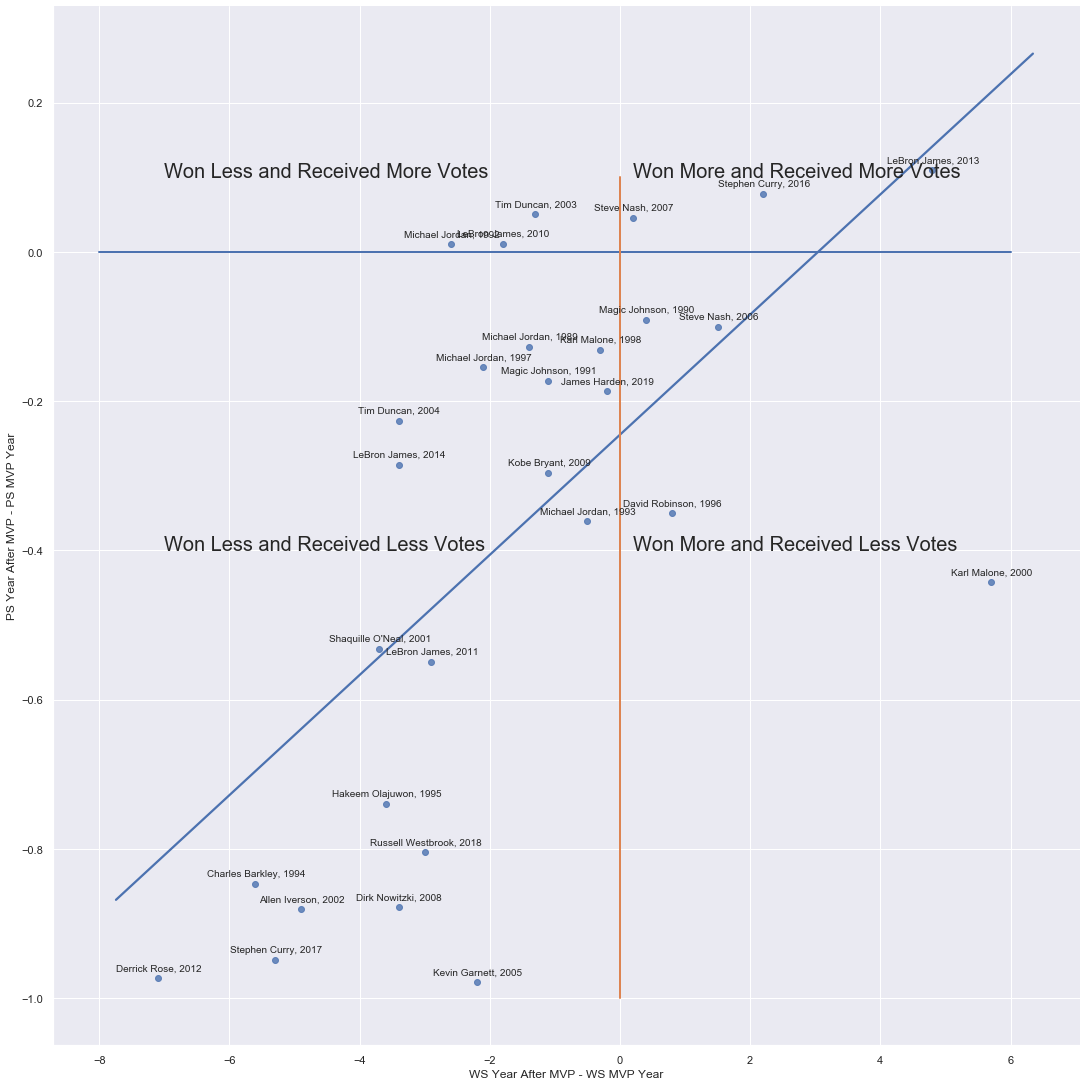

In [4]:
g = sns.FacetGrid(chart_df, height=15)
order=1
mvp_chart_df = chart_df
x_data = chart_df[l1].values
y_data = chart_df[l2].values
mvp_z = np.polyfit(x_data, y_data, order)
print(mvp_z)
g = g.map(sns.regplot, x=l1, y=l2, data=chart_df, ci=None, order=order)
for row in chart_df.iterrows():
    g.axes[0,0].text(row[1][l1]+0.01, row[1][l2]+0.01, row[1]['Player'], horizontalalignment='center')
    
g.axes[0,0].text(0.2, 0.10, 'Won More and Received More Votes', fontsize=20)
g.axes[0,0].text(-7, 0.10, 'Won Less and Received More Votes', fontsize=20)
g.axes[0,0].text(0.2, -0.4, 'Won More and Received Less Votes', fontsize=20)
g.axes[0,0].text(-7, -0.4, 'Won Less and Received Less Votes', fontsize=20)
g.axes[0, 0].plot([-8, 6], [0, 0], linewidth=2)
g.axes[0, 0].plot([0, 0], [0.1, -1], linewidth=2)
g.axes[0,0].set_xlabel(l1)
g.axes[0,0].set_ylabel(l2)
plt.show()

### DPOY Award

Let's perform the same analysis for the DPOY award.

In [5]:
df = pd.read_csv('dpoy_data.csv')
df.head()

,RANK,PLAYER,AGE,TEAM,FIRST_PLACE_VOTES,TOTAL_POINTS_WON,TOTAL_POINTS_POSSIBLE,POINTS_SHARE,G,MP,...,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,SEASON,DWS
0,1,Michael Jordan,24,CHI,37.0,37.0,80,0.463,82,40.4,...,5.9,3.2,1.6,0.535,0.132,0.841,21.2,0.308,1988,6.1
1,2,Mark Eaton,31,UTA,9.0,9.0,80,0.113,82,33.3,...,0.7,0.5,3.7,0.418,NaN,0.623,4.1,0.072,1988,5.2
2,3,Hakeem Olajuwon,25,HOU,7.0,7.0,80,0.088,79,35.8,...,2.1,2.1,2.7,0.514,0.000,0.695,10.7,0.182,1988,6.3
3,4,Alvin Robertson,25,SAS,6.0,6.0,80,0.075,82,36.3,...,6.8,3.0,0.8,0.465,0.284,0.748,5.8,0.094,1988,2.8
4,5T,Michael Cooper,31,LAL,4.0,4.0,80,0.050,61,29.4,...,4.7,1.1,0.4,0.392,0.320,0.858,3.1,0.082,1988,1.8


In [6]:
l1 = 'DWS Year After DPOY - DWS DPOY Year'
l2 = 'PS Year After DPOY - PS DPOY Year'

chart_df = pd.DataFrame(columns=[l1, l2, 'Player'])
for y in df['SEASON'].unique():
    if y==1988: continue
    prev_y = y-1
    prev_y_df = df[df['SEASON']==prev_y]
    prev_winner = prev_y_df[prev_y_df['RANK']=='1']
    if len(prev_winner)==0: continue
    y_df = df[df['SEASON']==y]
    prev_winner_name = prev_winner['PLAYER'].values[0]
    prev_winner_now = y_df[y_df['PLAYER']==prev_winner_name]
    if len(prev_winner_now)==0: continue
    ws_drop_off = prev_winner_now['DWS'].values[0]-prev_winner['DWS'].values[0]
    ps_drop_off = prev_winner_now['POINTS_SHARE'].values[0]-prev_winner['POINTS_SHARE'].values[0]
    # large ws drop off indicates that someone deserved to have a large ps drop off
    chart_df = chart_df.append({l1: ws_drop_off, l2: ps_drop_off, 'Player': prev_winner_name+', '+str(y)}, ignore_index=True)

[ 0.09736021 -0.26654382]


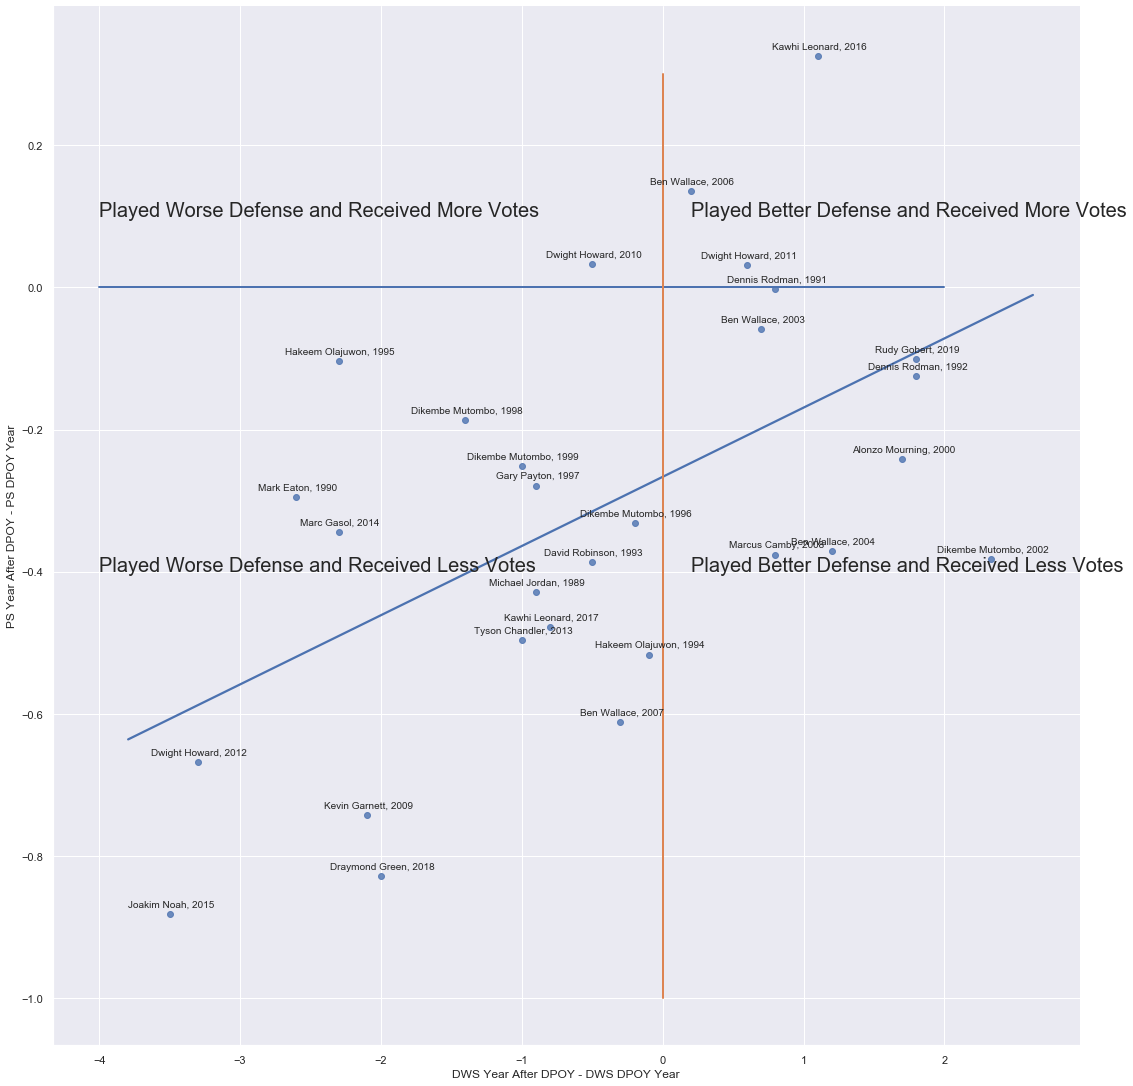

In [7]:
g = sns.FacetGrid(chart_df, height=15)
order=1
dpoy_chart_df = chart_df
x_data = chart_df[l1].values
y_data = chart_df[l2].values
dpoy_z = np.polyfit(x_data, y_data, order)
print(dpoy_z)
g = g.map(sns.regplot, x=l1, y=l2, data=chart_df, ci=None, order=order)
for row in chart_df.iterrows():
    g.axes[0,0].text(row[1][l1]+0.01, row[1][l2]+0.01, row[1]['Player'], horizontalalignment='center')
    
g.axes[0,0].text(0.2, 0.10, 'Played Better Defense and Received More Votes', fontsize=20)
g.axes[0,0].text(-4, 0.10, 'Played Worse Defense and Received More Votes', fontsize=20)
g.axes[0,0].text(0.2, -0.4, 'Played Better Defense and Received Less Votes', fontsize=20)
g.axes[0,0].text(-4, -0.4, 'Played Worse Defense and Received Less Votes', fontsize=20)
g.axes[0, 0].plot([-4, 2], [0, 0], linewidth=2)
g.axes[0, 0].plot([0, 0], [0.3, -1], linewidth=2)
g.axes[0,0].set_xlabel(l1)
g.axes[0,0].set_ylabel(l2)
plt.show()

### MIP Award

In [8]:
df = pd.read_csv('mip_data.csv')
df.head()

,RANK,PLAYER,AGE,TEAM,FIRST_PLACE_VOTES,TOTAL_POINTS_WON,TOTAL_POINTS_POSSIBLE,POINTS_SHARE,G,MP,...,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,SEASON,CURR_PER-PREV_PER
0,1,Kevin Duckworth,23,POR,33.0,33.0,80,0.413,78,28.5,...,0.8,0.4,0.4,0.496,NaN,0.770,5.2,0.112,1988,5.4
1,2,John Stockton,25,UTA,15.0,15.0,80,0.188,82,34.7,...,13.8,3.0,0.2,0.574,0.358,0.840,14.1,0.238,1988,4.2
2,3,Mark Price,23,CLE,11.0,11.0,80,0.138,80,32.8,...,6.0,1.2,0.2,0.506,0.486,0.877,7.8,0.143,1988,6.3
3,4,Michael Adams,25,DEN,7.0,7.0,80,0.088,82,33.9,...,6.1,2.0,0.2,0.449,0.367,0.834,7.5,0.130,1988,1.3
4,5,Jerome Kersey,25,POR,5.0,5.0,80,0.063,79,36.6,...,3.1,1.6,0.8,0.499,0.200,0.735,8.6,0.144,1988,0.4


In [9]:
l1 = 'PER Improvement Year After MIP - PER Improvement MIP Year'
l2 = 'PS Year After MIP - PS MIP Year'

chart_df = pd.DataFrame(columns=[l1, l2, 'Player'])
for y in df['SEASON'].unique():
    if y==1988: continue
    prev_y = y-1
    prev_y_df = df[df['SEASON']==prev_y]
    prev_winner = prev_y_df[prev_y_df['RANK']=='1']
    if len(prev_winner)==0: continue
    y_df = df[df['SEASON']==y]
    prev_winner_name = prev_winner['PLAYER'].values[0]
    prev_winner_now = y_df[y_df['PLAYER']==prev_winner_name]
    if len(prev_winner_now)==0: continue
    ws_drop_off = prev_winner_now['CURR_PER-PREV_PER'].values[0]-prev_winner['CURR_PER-PREV_PER'].values[0]
    ps_drop_off = prev_winner_now['POINTS_SHARE'].values[0]-prev_winner['POINTS_SHARE'].values[0]
    # large ws drop off indicates that someone deserved to have a large ps drop off
    chart_df = chart_df.append({l1: ws_drop_off, l2: ps_drop_off, 'Player': prev_winner_name+', '+str(y)}, ignore_index=True)

[ 0.0255688  -0.51181455]


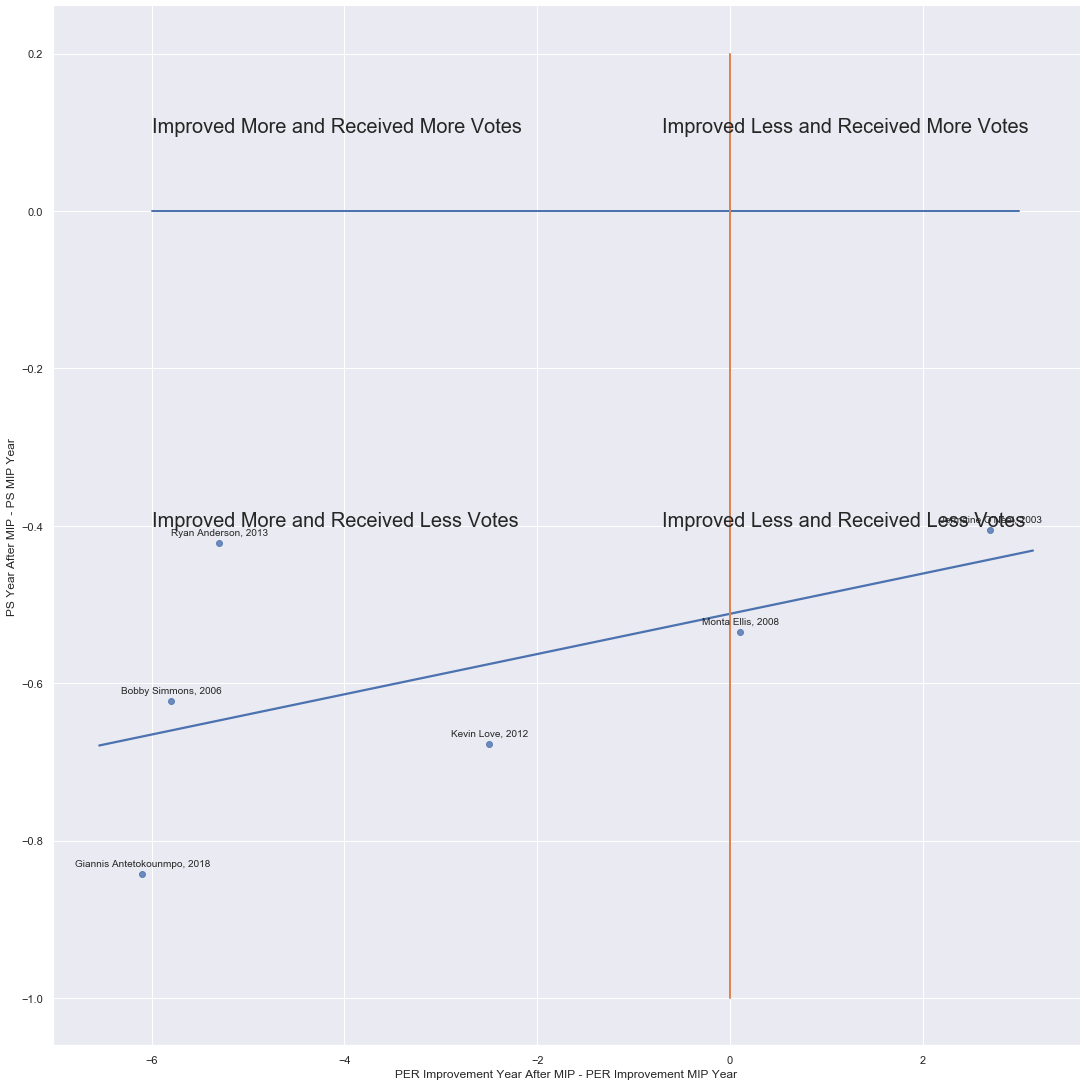

In [10]:
g = sns.FacetGrid(chart_df, height=15)
order=1
mip_chart_df = chart_df
x_data = chart_df[l1].values
y_data = chart_df[l2].values
mip_z = np.polyfit(x_data, y_data, order)
print(mip_z)
g = g.map(sns.regplot, x=l1, y=l2, data=chart_df, ci=None, order=order)
for row in chart_df.iterrows():
    g.axes[0,0].text(row[1][l1]+0.01, row[1][l2]+0.01, row[1]['Player'], horizontalalignment='center')
    
g.axes[0,0].text(-6, 0.10, 'Improved More and Received More Votes', fontsize=20)
g.axes[0,0].text(-0.7, 0.10, 'Improved Less and Received More Votes', fontsize=20)
g.axes[0,0].text(-6, -0.4, 'Improved More and Received Less Votes', fontsize=20)
g.axes[0,0].text(-0.7, -0.4, 'Improved Less and Received Less Votes', fontsize=20)
g.axes[0, 0].plot([-6, 3], [0, 0], linewidth=2)
g.axes[0, 0].plot([0, 0], [0.2, -1], linewidth=2)
g.axes[0,0].set_xlabel(l1)
g.axes[0,0].set_ylabel(l2)
plt.show()

Evidently, there is insufficient data to say anything significant about the MIP award.

### SMOY Award

In [11]:
df = pd.read_csv('smoy_data.csv')
df.head()

,RANK,PLAYER,AGE,TEAM,FIRST_PLACE_VOTES,TOTAL_POINTS_WON,TOTAL_POINTS_POSSIBLE,POINTS_SHARE,G,MP,...,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,SEASON,PER
0,1,Roy Tarpley,23,DAL,67.0,67.0,80,0.838,81,28.5,...,1.1,1.3,1.1,0.500,0.000,0.740,7.8,0.163,1988,19.5
1,2,Thurl Bailey,26,UTA,13.0,13.0,80,0.163,82,34.2,...,1.9,0.6,1.5,0.492,0.333,0.826,6.8,0.116,1988,16.3
2,1,Eddie Johnson,29,PHO,33.0,33.0,85,0.388,70,29.2,...,2.3,0.7,0.1,0.497,0.413,0.868,6.5,0.152,1989,NaN
3,2,Thurl Bailey,27,UTA,26.0,26.0,85,0.306,82,33.9,...,1.7,0.6,1.1,0.483,0.400,0.825,6.5,0.113,1989,15.6
4,3,Dennis Rodman,27,DET,17.0,17.0,85,0.200,82,26.9,...,1.2,0.7,0.9,0.595,0.231,0.626,8.1,0.175,1989,16.3


In [12]:
l1 = 'PER Year After SMOY - PER SMOY Year'
l2 = 'PS Year After SMOY - PS SMOY Year'

chart_df = pd.DataFrame(columns=[l1, l2, 'Player'])
for y in df['SEASON'].unique():
    if y==1988: continue
    prev_y = y-1
    prev_y_df = df[df['SEASON']==prev_y]
    prev_winner = prev_y_df[prev_y_df['RANK']=='1']
    if len(prev_winner)==0: continue
    y_df = df[df['SEASON']==y]
    prev_winner_name = prev_winner['PLAYER'].values[0]
    prev_winner_now = y_df[y_df['PLAYER']==prev_winner_name]
    if len(prev_winner_now)==0: continue
    ws_drop_off = prev_winner_now['PER'].values[0]-prev_winner['PER'].values[0]
    ps_drop_off = prev_winner_now['POINTS_SHARE'].values[0]-prev_winner['POINTS_SHARE'].values[0]
    # large ws drop off indicates that someone deserved to have a large ps drop off
    chart_df = chart_df.append({l1: ws_drop_off, l2: ps_drop_off, 'Player': prev_winner_name+', '+str(y)}, ignore_index=True)

[ 0.08159693 -0.33335873]


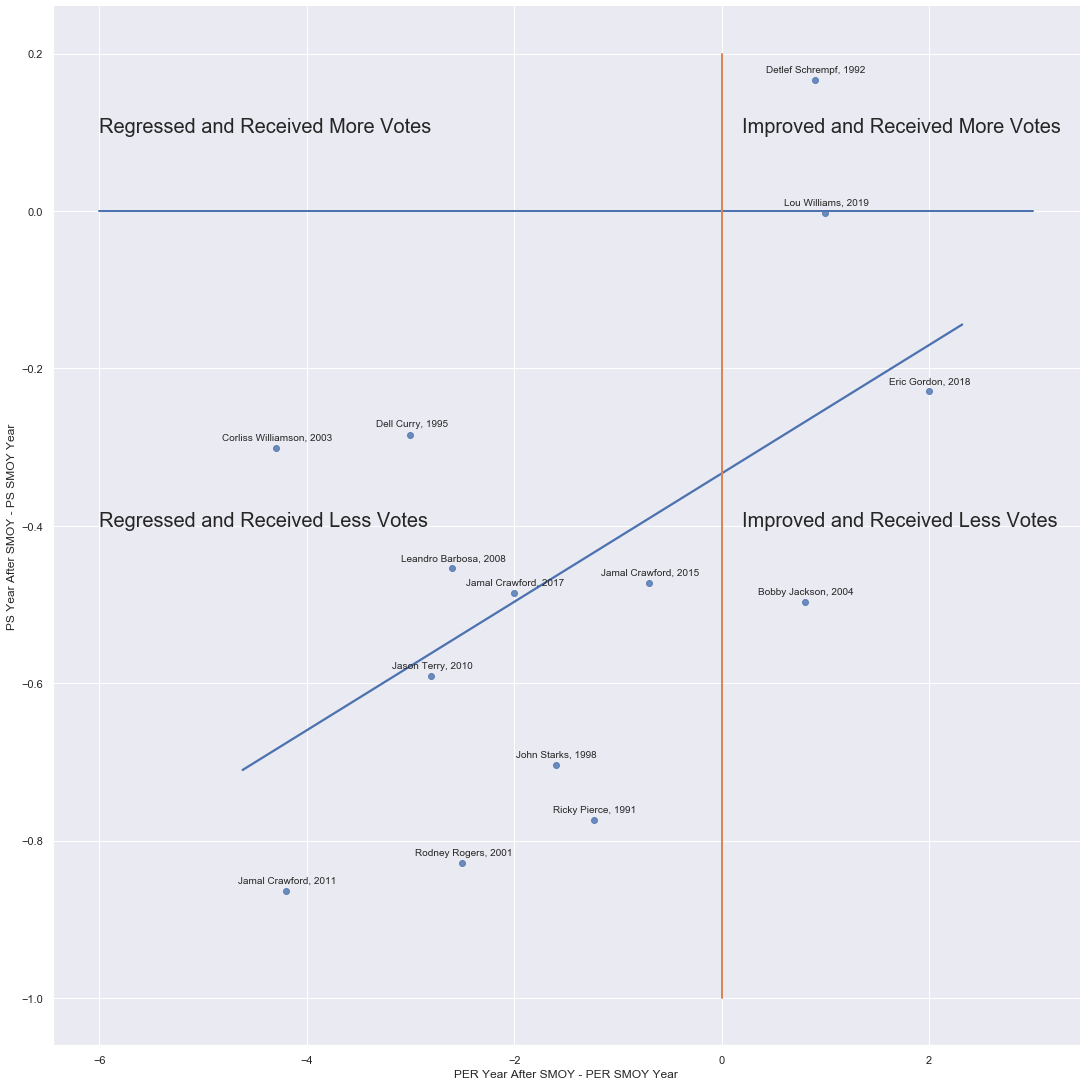

In [13]:
chart_df.dropna(inplace=True)
g = sns.FacetGrid(chart_df, height=15)
order=1
smoy_chart_df = chart_df
x_data = chart_df[l1].values
y_data = chart_df[l2].values
smoy_z = np.polyfit(x_data, y_data, order)
print(smoy_z)
g = g.map(sns.regplot, x=l1, y=l2, data=chart_df, ci=None, order=order)
for row in chart_df.iterrows():
    g.axes[0,0].text(row[1][l1]+0.01, row[1][l2]+0.01, row[1]['Player'], horizontalalignment='center')
    
g.axes[0,0].text(0.2, 0.10, 'Improved and Received More Votes', fontsize=20)
g.axes[0,0].text(-6, 0.10, 'Regressed and Received More Votes', fontsize=20)
g.axes[0,0].text(0.2, -0.4, 'Improved and Received Less Votes', fontsize=20)
g.axes[0,0].text(-6, -0.4, 'Regressed and Received Less Votes', fontsize=20)
g.axes[0, 0].plot([-6, 3], [0, 0], linewidth=2)
g.axes[0, 0].plot([0, 0], [0.2, -1], linewidth=2)
g.axes[0,0].set_xlabel(l1)
g.axes[0,0].set_ylabel(l2)
plt.show()

### COY Award

In [14]:
df = pd.read_csv('coy_data.csv')
df.head()

,COACH,POINTS,SEASON,TEAM,W-PW,POINTS_SHARE
0,Mike Budenholzer,432,2019,MIL,-1.0,0.480000
1,Doc Rivers,200,2019,LAC,5.0,0.222222
2,Mike Malone,154,2019,DEN,3.0,0.171111
3,Nate McMillan,62,2019,IND,-2.0,0.068889
4,Kenny Atkinson,36,2019,BRK,1.0,0.040000


In [15]:
l1 = 'Win Differential After COY - Win Differential COY Year'
l2 = 'PS Year After COY - PS COY Year'

chart_df = pd.DataFrame(columns=[l1, l2, 'Coach'])
for y in df['SEASON'].unique():
    if y==1988: continue
    prev_y = y-1
    prev_y_df = df[df['SEASON']==prev_y]
    prev_winner = prev_y_df[:1]
    if len(prev_winner)==0: continue
    y_df = df[df['SEASON']==y]
    prev_winner_name = prev_winner['COACH'].values[0]
    prev_winner_now = y_df[y_df['COACH']==prev_winner_name]
    if len(prev_winner_now)==0: continue
    ws_drop_off = prev_winner_now['W-PW'].values[0]-prev_winner['W-PW'].values[0]
    ps_drop_off = prev_winner_now['POINTS_SHARE'].values[0]-prev_winner['POINTS_SHARE'].values[0]
    # large ws drop off indicates that someone deserved to have a large ps drop off
    chart_df = chart_df.append({l1: ws_drop_off, l2: ps_drop_off, 'Coach': prev_winner_name+', '+str(y)}, ignore_index=True)

[-0.00767806 -0.37150997]


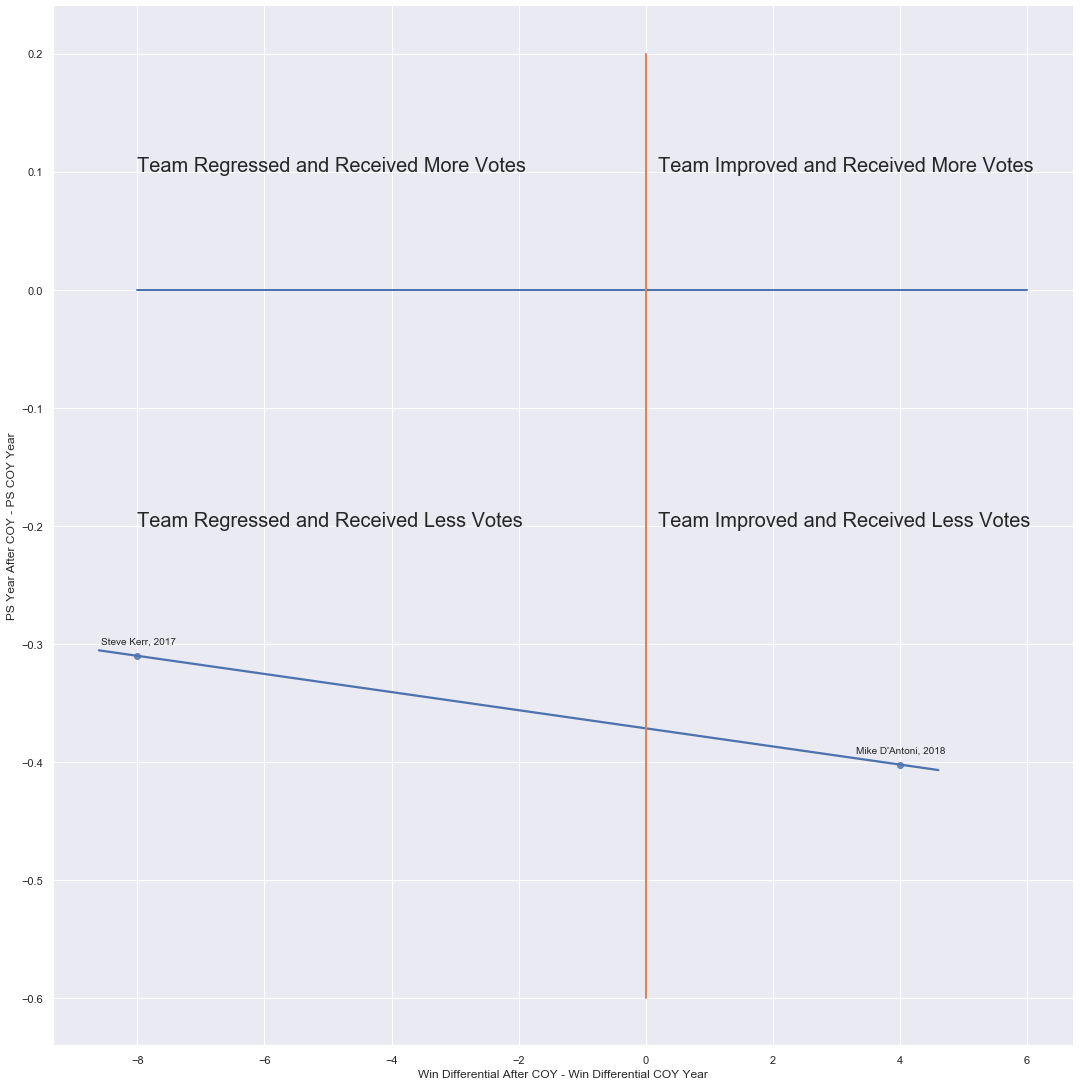

In [16]:
g = sns.FacetGrid(chart_df, height=15)
order=1
x_data = chart_df[l1].values
y_data = chart_df[l2].values
coy_z = np.polyfit(x_data, y_data, order)
print(coy_z)
g = g.map(sns.regplot, x=l1, y=l2, data=chart_df, ci=None, order=order)
for row in chart_df.iterrows():
    g.axes[0,0].text(row[1][l1]+0.01, row[1][l2]+0.01, row[1]['Coach'], horizontalalignment='center')
    
g.axes[0,0].text(0.2, 0.10, 'Team Improved and Received More Votes', fontsize=20)
g.axes[0,0].text(-8, 0.10, 'Team Regressed and Received More Votes', fontsize=20)
g.axes[0,0].text(0.2, -0.2, 'Team Improved and Received Less Votes', fontsize=20)
g.axes[0,0].text(-8, -0.2, 'Team Regressed and Received Less Votes', fontsize=20)
g.axes[0, 0].plot([-8, 6], [0, 0], linewidth=2)
g.axes[0, 0].plot([0, 0], [0.2, -0.6], linewidth=2)
g.axes[0,0].set_xlabel(l1)
g.axes[0,0].set_ylabel(l2)
plt.show()

Two data points consisting of Steve Kerr and Mike D'Antoni is insufficient, so we can't really say much about COY. 

## Summary

Let's take a look at all the best fit lines along with the corresponding x-intercepts for the awards we *can* say something about (MVP, DPOY, SMOY).

In [39]:
def shot_line_stats(label, z):
    print(label.upper())
    print('Best fit line:')
    print(f'y={z[0]}*x+({z[1]})')
    x_intercept = -z[1]/z[0]
    print(f'x-intercept: {x_intercept}' )
    print('\n')

In [40]:
shot_line_stats('mvp', mvp_z)
shot_line_stats('dopy', dpoy_z)
shot_line_stats('smoy', smoy_z)

MVP
Best fit line:
y=0.08050905774386342*x+(-0.24492895462768918)
x-intercept: 3.042253399697231


DOPY
Best fit line:
y=0.09736020500961524*x+(-0.26654381850154735)
x-intercept: 2.7377080653766455


SMOY
Best fit line:
y=0.08159692715800439*x+(-0.33335872670259853)
x-intercept: 4.085432360180455




# Conclusions and Takeaways

So what does this mean for each of the awards listed above?

**To repeat as MVP, an individual must increase his win shares by ~3.042.**

**To repeat as DPOY, an individual must increase his defensive win shares by ~2.738.**

**To repeat as SMOY, an individual must increase his PER by ~4.085.**

Now, not all of these statistics are on the same scale. Of course, Win Shares and Defensive Win Shares are on a similar scale so we can compare them relatively easily.

PER, on the other hand, is on a separate scale. However, we can easily eyeball the scale by comparing the relative PER and WS of top recent candidates.

Consider Giannis Antetokounmpo. His WS is 8.1 PER is 32.7 

Consider James Harden. His WS is 8.7 PER is 29.4

Generally, the same pattern holds where a player's PER is approximately 3-4x his WS. 

Evidently, WS and DWS is a metric **signficantly** harder to increase than PER. So increasing a player's PER by ~4 is signficantly easier than increasing a player's WS or DWS by ~3.

As a result, we can fairly certainly say that the difficulty to repeat in one of the three awards (i.e. get the same amount of POINTS_SHARE) it can be ordered in difficulty as follows:

**1) MVP**

**2) DPOY**

**3) SMOY**

With MVP and DPOY being of similar difficulty, but SMOY being significantly easier.

We can, thus, conclude that voter fatigue affects the MVP award the most, followed by DPOY and then SMOY.